In [1]:
import os

# --- 1. THIẾT LẬP HẰNG SỐ SEED ---
SEED = 42

# --- 2. CẤU HÌNH BIẾN MÔI TRƯỜNG ---

# PYTHONHASHSEED:
# - Python dùng hàm băm (hash) ngẫu nhiên cho Dictionary/Set để bảo mật.
# - Cần cố định nó để đảm bảo việc xử lý chuỗi (Text) luôn ra kết quả giống nhau.
os.environ['PYTHONHASHSEED'] = str(SEED)

# --- 3. IMPORT THƯ VIỆN ---
import random
import numpy as np
import pandas as pd
import tensorflow as tf

# --- 4. HÀM THIẾT LẬP SEED TOÀN CỤC ---
def set_seed(seed=SEED):
    """
    Hàm này khóa (freeze) tất cả các bộ sinh số ngẫu nhiên.
    Đảm bảo tính tái lập (Reproducibility) của thí nghiệm.
    """
    # Khóa seed của thư viện chuẩn Python (dùng cho random.choice, shuffle...)
    random.seed(seed)
    
    # Khóa seed của Numpy (dùng cho np.random, pandas sample, scikit-learn split...)
    np.random.seed(seed)
    
    # Khóa seed của TensorFlow (dùng cho việc khởi tạo trọng số Weight/Bias ban đầu)
    tf.random.set_seed(seed)
    
    print(f"Thiết lập Global Seed: {seed}")

# Gọi hàm ngay lập tức để áp dụng cấu hình
set_seed(SEED)

# --- 5. KIỂM TRA DỮ LIỆU ĐẦU VÀO ---
print("\nDanh sách file dữ liệu tìm thấy:")
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

2026-02-24 16:07:12.592664: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771949232.778249      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771949232.831620      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771949233.248913      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771949233.248957      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771949233.248960      55 computation_placer.cc:177] computation placer alr

Thiết lập Global Seed: 42

Danh sách file dữ liệu tìm thấy:
/kaggle/input/real-dataset-30-phishing/phishing_dataset_full_46k.csv
/kaggle/input/phishing-site-urls/phishing_site_urls.csv
/kaggle/input/datasets/quangnguynv/real-data-url-for-fine-tune/phishing_dataset_final.csv
/kaggle/input/real-world-phishing-url-classification-data/phishing_url_dataset_unique.csv
/kaggle/input/top1m/top-1m.csv


In [2]:
# Chọn tập data Phishing-site-urls và tập Real-world-phishing làm tập train
path_data1 = ""
path_data2 = ""

# Lệnh này quét toàn bộ thư mục Input
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        full_path = os.path.join(dirname, filename)

        if "phishing_site_urls.csv" in filename:
            path_data1 = full_path
            print(f"Tập data1 tại: {path_data1}")

        elif "phishing_url_dataset_unique.csv" in filename:
            path_data2 = full_path
            print(f"Tập data2 tại: {path_data2}")

Tập data1 tại: /kaggle/input/phishing-site-urls/phishing_site_urls.csv
Tập data2 tại: /kaggle/input/real-world-phishing-url-classification-data/phishing_url_dataset_unique.csv


In [3]:
import re

# Xóa giao thức, chỉ giữ lại domain url
def clean_url(url):
    # 1. Chuyển thành chuỗi và chữ thường -> giúp giảm độ phức tạp mô hình -> giảm overfiting
    url = str(url).lower()
    
    # 2. Xóa protocol và www
    url = re.sub(r'^https?://', '', url)
    url = re.sub(r'^www\.', '', url)
    
    return url

In [4]:
import urllib.parse

# 1. Danh sách các domain rút gọn
SHORTENER_DOMAINS = {
    'bit.ly', 'tinyurl.com', 't.co', 'goo.gl', 'ow.ly', 'is.gd', 
    'buff.ly', 'adf.ly', 'bit.do', 'cutt.ly', 'v.gd', 'j.mp'
}

def is_short(url):
    try:
        if not url.startswith(('http://', 'https://')):
            url = 'http://' + url
        domain = urllib.parse.urlparse(url).netloc.replace('www.', '')
        return domain in SHORTENER_DOMAINS
    except:
        return False

In [5]:
import re

# COMPILED PATTERNS
VALUE_BASED_RULES = {
    # 1. NETWORK ADDRESSES
    '<IPV4>': re.compile(
        r'\b(?:(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.){3}'
        r'(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\b'
    ),
    '<IPV6>': re.compile(
        r'\[?(?:[a-fA-F0-9]{0,4}:){2,7}[a-fA-F0-9]{0,4}\]?'
    ),
    '<MAC_ADDRESS>': re.compile(
        r'(\b)((?:[0-9a-fA-F]{2}[:-]){5}[0-9a-fA-F]{2})(?=\b)'
    ),
    
    # 2. TIME & DATE
    '<DATE>': re.compile(
        r'(\b|/)((?:19|20)\d{2}[-/.](?:0[1-9]|1[0-2])[-/.](?:0[1-9]|[12]\d|3[01]))'
        r'(?=\b|/|$)'
    ),

    # 3. IDs IN PATH
    '<NUMERIC_ID>': re.compile(r'(/)(\d{6,})(?=/|[?#]|$)'),
    '<HEX_ID>': re.compile(r'(/)([\da-fA-F]{15,})(?=/|[?#]|$)'),

    # 4. CRYPTO WALLETS
    '<ETH_WALLET>': re.compile(r'(\b)(0x[\da-fA-F]{40})(?=\b)'),
    '<BTC_WALLET>': re.compile(r'(\b)([13][\da-km-zA-HJ-NP-Z]{25,34})(?=\b)'),
    
    # 5. QUERY STRING PARAMETERS
    '<UUID_FORMAT>': re.compile(
        r'([?&][^=]+=)([\da-fA-F]{8}-[\da-fA-F]{4}-[\da-fA-F]{4}-'
        r'[\da-fA-F]{4}-[\da-fA-F]{12})(?=[&#]|$)'
    ),
    '<JWT_FORMAT>': re.compile(r'([?&][^=]+=)(eyJ[\w-]+\.[\w-]+\.[\w-]+)(?=[&#]|$)'),
    '<BASE64_FORMAT>': re.compile(r'([?&][^=]+=)([\w+/\-]{30,}={0,2})(?=[&#]|$)'),
    '<HASH_FORMAT>': re.compile(r'([?&][^=]+=)([\da-fA-F]{32}|[\da-fA-F]{40}|[\da-fA-F]{64})(?=[&#]|$)'),
    '<EMAIL>': re.compile(r'([?&][^=]+=)([\w.%+-]+@[\w.-]+\.[a-zA-Z]{2,})(?=[&#]|$)'),
}

NAME_BASED_RULES = {
    '<ID>': re.compile(r'([?&](?:id|uid|user_id|account_id)=)([^&#<]+)', flags=re.IGNORECASE),
    '<SESSION_ID>': re.compile(r'([?&](?:session|sid|sessionid|PHPSESSID|JSESSIONID)=)([^&#<]+)', flags=re.IGNORECASE),
    '<TOKEN>': re.compile(r'([?&](?:token|access_token|auth|api_key|key)=)([^&#<]+)', flags=re.IGNORECASE),
    '<TIMESTAMP>': re.compile(r'([?&](?:timestamp|ts|time|t|_t)=)([^&#<]+)', flags=re.IGNORECASE),
    '<REF>': re.compile(r'([?&](?:ref|reference|referrer|returnUrl|next|redirect)=)([^&#<]+)', flags=re.IGNORECASE),
    '<OAUTH_PARAM>': re.compile(r'([?&](?:code|state|nonce|sig|signature)=)([^&#<]+)', flags=re.IGNORECASE),
    '<IP_PARAM>': re.compile(r'([?&](?:ip|ip_address|remote_addr|client_ip)=)([^&#<]+)', flags=re.IGNORECASE),
}

# HÀM SANITIZE CHÍNH

def get_length_replacer(mask_tag):
    """
    Hàm sinh ra một hàm replace động.
    Ví dụ: mask_tag = '<HEX_ID>'
    Kết quả replace sẽ là: Nhóm 1 (tiền tố) + '<HEX_ID_ĐộDài>'
    """
    base_tag = mask_tag[1:-1] # Cắt bỏ ngoặc < > để lấy chữ 'HEX_ID'
    
    def replacer(match):
        prefix = match.group(1)   # Ví dụ: '/' hoặc '?id='
        target = match.group(2)   # Ví dụ: đoạn mã Hex thực tế
        length = len(target)      # Đo độ dài đoạn mã
        return f"{prefix}<{base_tag}_{length}>"
        
    return replacer

def sanitize_url(url):
    """
    Sanitize URL by masking sensitive parameters AND tracking their lengths
    """
    if not isinstance(url, str):
        return url
        
    if not url or len(url) < 10:
        return url
        
    masked_url = url

    # STEP 1: Unify IP addresses 
    masked_url = VALUE_BASED_RULES['<IPV4>'].sub('<IP_ADDRESS>', masked_url)
    masked_url = VALUE_BASED_RULES['<IPV6>'].sub('<IP_ADDRESS>', masked_url)

    # STEP 2: Process DATE first (Đo độ dài ngày tháng)
    masked_url = VALUE_BASED_RULES['<DATE>'].sub(get_length_replacer('<DATE>'), masked_url)

    # STEP 3: Other value-based patterns
    for mask_tag, compiled_pattern in VALUE_BASED_RULES.items():
        if mask_tag in ['<IPV4>', '<IPV6>', '<DATE>']:
            continue
        masked_url = compiled_pattern.sub(get_length_replacer(mask_tag), masked_url)
        
    # STEP 4: Name-based patterns
    for mask_tag, compiled_pattern in NAME_BASED_RULES.items():
        masked_url = compiled_pattern.sub(get_length_replacer(mask_tag), masked_url)
        
    return masked_url

In [6]:
# Xử lý bộ dữ liệu training 

# 1. Đọc file
df_data1 = pd.read_csv(path_data1)
df_data2 = pd.read_csv(path_data2)

In [7]:
df_data1.head()

,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad
3,mail.printakid.com/www.online.americanexpress....,bad
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad


In [8]:
df_data2.drop(columns='source', inplace=True) # không cần cột này nên loại bỏ
df_data2.head()

,url,label
0,http://110.37.26.193:54956/bin.sh,1
1,https://sentry5.obor1shwron8.ru/4ylkytvt,1
2,https://d6gu.ripple-cask.ru/jid43vpd,1
3,http://130.12.180.34/596a96cc7bf9108cd896f33c4...,1
4,https://bronze.systems,0


In [9]:
# 2. Chuyển nhãn từ chữ sang số
# Nếu là 'bad' (phishing) thì gán nhãn 1, ngược lại là 0
df_data1['Label'] = df_data1['Label'].apply(lambda x: 1 if x == 'bad' else 0)

# 3. Clean URL
df_data1['URL'] = df_data1['URL'].apply(lambda x: clean_url(x))

# Xem thử 5 dòng đầu tiên
print(df_data1.head())

                                                 URL  Label
0  nobell.it/70ffb52d079109dca5664cce6f317373782/...      1
1  dghjdgf.com/paypal.co.uk/cycgi-bin/webscrcmd=_...      1
2  serviciosbys.com/paypal.cgi.bin.get-into.herf....      1
3  mail.printakid.com/www.online.americanexpress....      1
4  thewhiskeydregs.com/wp-content/themes/widescre...      1


In [10]:
# Kiểm tra lại file data1
# Kiểm tra giá trị rỗng
df_data1.isnull().sum().sum()

np.int64(0)

In [11]:
df_data1['Label'].value_counts()
# 1 là phishing
# 0 là an toàn

Label
0    392924
1    156422
Name: count, dtype: int64

In [12]:
# Xử lý bộ dữ liệu data2
df_data2.rename(columns={'url': 'URL'}, inplace=True)
df_data2.rename(columns={'label': 'Label'}, inplace=True)

In [13]:
# Clean URL
df_data2['URL'] = df_data2['URL'].apply(lambda x: clean_url(x))

# Xem thử 5 dòng đầu tiên
print(df_data2.head())

                                                 URL  Label
0                         110.37.26.193:54956/bin.sh      1
1                   sentry5.obor1shwron8.ru/4ylkytvt      1
2                       d6gu.ripple-cask.ru/jid43vpd      1
3  130.12.180.34/596a96cc7bf9108cd896f33c44aedc8a...      1
4                                     bronze.systems      0


In [14]:
# Kiểm tra giá trị rỗng
df_data2.isnull().sum().sum()

np.int64(0)

In [15]:
df_data2['Label'].value_counts()
# 1 là phishing
# 0 là an toàn

Label
1    24406
0    24406
Name: count, dtype: int64

In [16]:
# Gộp 2 dữ liệu và trộn
df_train = pd.concat([df_data1, df_data2], ignore_index=True)

# Xóa các dòng bị trùng lặp sau khi gộp
df_train = df_train.drop_duplicates()
df_train = df_train.sample(frac=1, random_state=SEED).reset_index(drop=True)

print(f"Số lượng URL ban đầu: {len(df_train)}")
df_train = df_train[~df_train['URL'].apply(is_short)]
print(f"Số lượng URL sau khi xóa bỏ link rút gọn: {len(df_train)}")

# Token hóa các tham số, các mã băm, khóa phiên,.. tránh nhiễu model
df_train['URL'] = df_train['URL'].apply(sanitize_url)

Số lượng URL ban đầu: 554996
Số lượng URL sau khi xóa bỏ link rút gọn: 554338


In [17]:
df_train['Label'].value_counts()
# 1 là phishing
# 0 là an toàn

Label
0    417252
1    137086
Name: count, dtype: int64

In [42]:
# Tập dữ liệu test 
df_test = pd.read_csv('/kaggle/input/datasets/quangnguynv/real-data-url-for-fine-tune/phishing_dataset_final.csv')
df_test['URL'] = df_test['URL'].apply(lambda x: clean_url(x))
print(f"Số lượng URL ban đầu: {len(df_test)}")

# Xóa các dòng bị trùng lặp
df_test = df_test.drop_duplicates()
df_test = df_test.sample(frac=1, random_state=SEED).reset_index(drop=True)
print(f"Số lượng URL sau khi bỏ link trùng lặp: {len(df_test)}")

df_test = df_test[~df_test['URL'].apply(is_short)]
print(f"Số lượng URL sau khi bỏ link rút gọn: {len(df_test)}")

# Token hóa các tham số, các mã băm, khóa phiên,.. tránh nhiễu model
df_test['URL'] = df_test['URL'].apply(sanitize_url)

Số lượng URL ban đầu: 186906
Số lượng URL sau khi bỏ link trùng lặp: 143719
Số lượng URL sau khi bỏ link rút gọn: 141008


In [19]:
df_test.head()

,URL,Label
0,ipfs.best-practice.se/ipfs/bafybeierd7h7bqqd4q...,1
1,q-r.to/bffmol?session=<BASE64_FORMAT_32>&ref=<...,1
2,qrco.de/bfpxr8?timestamp=<TIMESTAMP_10>,1
3,quip.com/c5a1afotrj9t/securely-sign-in-to-veri...,1
4,bbc.com/services?auth=<BASE64_FORMAT_32>&sort=...,0


In [20]:
df_test['Label'].value_counts()
# 1 là phishing
# 0 là an toàn

Label
0    87696
1    53312
Name: count, dtype: int64

In [21]:
# Kiểm tra trùng lặp giữa train và test
overlap = set(df_train['URL']).intersection(set(df_test['URL']))
print(f"Số URL trùng giữa train và test: {len(overlap)}")

# Loại bỏ URL trùng khỏi tập train tránh data leakage
df_train = df_train[~df_train['URL'].isin(overlap)]

Số URL trùng giữa train và test: 71


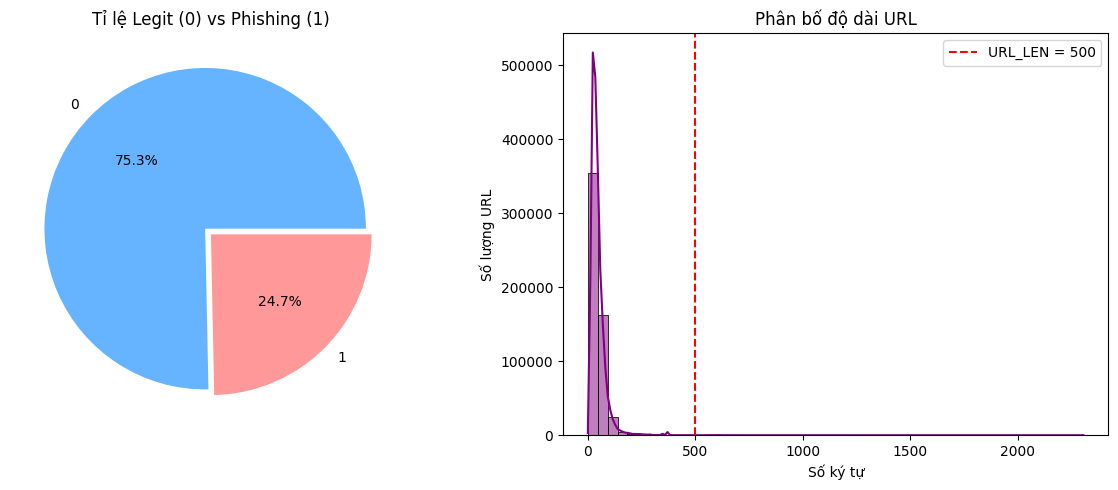

   - Độ dài trung bình: 47.16
   - URL dài nhất: 2307
   - Tỉ lệ URL ngắn hơn 500 ký tự: 99.94%


In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. BIỂU ĐỒ TRÒN: TỈ LỆ NHÃN 
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
df_train['Label'].value_counts().plot.pie(autopct='%1.1f%%', colors=['#66b3ff','#ff9999'], explode=(0.05, 0))
plt.title('Tỉ lệ Legit (0) vs Phishing (1)')
plt.ylabel('')

# 2. BIỂU ĐỒ CỘT: PHÂN BỐ ĐỘ DÀI URL
# Tính độ dài từng URL
url_lengths = df_train['URL'].apply(len)

plt.subplot(1, 2, 2)
sns.histplot(url_lengths, bins=50, kde=True, color='purple')
plt.axvline(x=500, color='r', linestyle='--', label='URL_LEN = 500') # Đường kẻ đỏ mốc cắt
plt.title('Phân bố độ dài URL')
plt.xlabel('Số ký tự')
plt.ylabel('Số lượng URL')
plt.legend()

plt.tight_layout()
plt.show()

# Thống kê nhanh
print(f"   - Độ dài trung bình: {url_lengths.mean():.2f}")
print(f"   - URL dài nhất: {url_lengths.max()}")
print(f"   - Tỉ lệ URL ngắn hơn 500 ký tự: {(url_lengths < 500).mean()*100:.2f}%")

In [23]:
from sklearn.model_selection import train_test_split

X = df_train['URL']
y = df_train['Label']

# Chia tập Train (80%) và Validation (20%) để kiểm tra 
X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=SEED,
    stratify=y  
)

print(f"Train={len(X_train)}, Val={len(X_val)}")

Train=443072, Val=110768


In [24]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle # Để lưu bộ từ điển

# --- CẤU HÌNH ---
VOCAB_SIZE = 150   # Số lượng ký tự phân biệt (đủ cho a-z, 0-9 và ký tự đặc biệt)
MAX_LEN = 500       # Cắt hoặc bù số 0 sao cho mọi URL dài bằng nhau (500 ký tự)

# 1. Chuẩn bị dữ liệu
X_train_raw = X_train.astype(str).values
y_train_raw = y_train.values

# 2. Khởi tạo Tokenizer mức ký tự
# THAM SỐ filters ĐỂ GIỮ LẠI DẤU <, > VÀ _
tokenizer = Tokenizer(
    num_words=VOCAB_SIZE, 
    char_level=True, 
    oov_token='<OOV>',
    filters='!"#$%&()*+,-./:;=?@[\\]^`{|}~\t\n'
)
tokenizer.fit_on_texts(X_train_raw)

# 3. Biến chữ thành số
sequences = tokenizer.texts_to_sequences(X_train_raw)

# 4. Đệm để độ dài bằng nhau
X_train = pad_sequences(sequences, maxlen=MAX_LEN, padding='post', truncating='post')

print(f"Ví dụ URL gốc: {X_train_raw[0]}")
print(f"Ví dụ URL số hóa: {X_train[0][:]}")

Ví dụ URL gốc: predry.sellmycolonyhome.com/search?ub=eoxc&amp;ybevn=kednvt2pq1fzy32&amp;qad1=tlzsmpm-cm&amp;w=kdgde8m-9ci-fjhgf&amp;wbek=oysog5-7xxyg8gttkgzgj1euu1&amp;tcxk=cmahesexid&amp;s=nsujjcjlsqeungad&amp;spe=nm
Ví dụ URL số hóa: [16 10  2 15 10 25 13  7  2 14 14 12 25  9  3 14  3 11 25 17  3 12  2 13
  9  3 12  8  7  2  4 10  9 17 44 19 21 34  2  3 32  9 46  4 12 16 48 25
 21  2 30 11 34 26  2 15 11 30  6 29 16 45 27 22 43 25 31 29 46  4 12 16
 48 45  4 15 27 34  6 14 43  7 12 16 12 18  9 12 46  4 12 16 48 24 34 26
 15 20 15  2 37 12 18 38  9  5 18 22 40 17 20 22 46  4 12 16 48 24 21  2
 26 34  3 25  7  3 20 36 18 39 32 32 25 20 37 20  6  6 26 20 43 20 40 27
  2 19 19 27 46  4 12 16 48  6  9 32 26 34  9 12  4 17  2  7  2 32  5 15
 46  4 12 16 48  7 34 11  7 19 40 40  9 40 14  7 45  2 19 11 20  4 15 46
  4 12 16 48  7 16  2 34 11 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0 

In [25]:
X_val_raw = X_val.astype(str).values 

# Biến chữ thành số (Dùng tokenizer đã fit trên train)
sequences_val = tokenizer.texts_to_sequences(X_val_raw)

# Padding
X_val = pad_sequences(sequences_val, maxlen=MAX_LEN, padding='post', truncating='post')

In [26]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

def get_class_weights(y):
    """
    Tính toán trọng số cho 2 lớp
    """
    y = np.array(y)
    classes = np.unique(y)
    weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
    
    class_weight = dict(zip(classes, weights))
    
    return class_weight

In [27]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import (
    Embedding, Conv1D, GlobalMaxPooling1D, MaxPooling1D, Dense, Dropout,
    Input, BatchNormalization, SpatialDropout1D, Activation, Add, GlobalAveragePooling1D,
    Concatenate, Reshape, Multiply
)

# --- THÔNG SỐ ---
EMBED_DIM = 64      
BATCH_SIZE = 128
EPOCHS = 35
L2_RATE = 5e-4
SE_RATIO = 16

# --- 1. SE BLOCK ---
def se_block(x, ratio=16):
    channels = x.shape[-1]
    reduced = max(channels // ratio, 8)  
    squeeze = GlobalAveragePooling1D()(x)
    excitation = Dense(reduced, activation='relu', use_bias=False)(squeeze)
    excitation = Dense(channels, activation='sigmoid', use_bias=False)(excitation)
    excitation = Reshape((1, channels))(excitation)
    scaled = Multiply()([x, excitation])
    return scaled

# --- 2. RESIDUAL BLOCK ---
def residual_block(x, filters, kernel_size):
    shortcut = x

    x = Conv1D(filters, kernel_size, padding='same',
               kernel_regularizer=l2(L2_RATE), 
               kernel_initializer='he_normal', # Khởi tạo trọng số tốt cho ReLU, tránh vanishing gradient
               use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(filters, kernel_size, padding='same',
               kernel_regularizer=l2(L2_RATE), 
               kernel_initializer='he_normal',
               use_bias=False)(x)
    x = BatchNormalization()(x)

    if shortcut.shape[-1] != filters:
        shortcut = Conv1D(filters, kernel_size=1, padding='same',
                          kernel_regularizer=l2(L2_RATE), 
                          kernel_initializer='he_normal',
                          use_bias=False)(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = se_block(x, ratio=SE_RATIO)
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

# --- 3. XÂY DỰNG MODEL ---
inputs = Input(shape=(MAX_LEN,))

x = Embedding(VOCAB_SIZE, EMBED_DIM)(inputs)
x = SpatialDropout1D(0.2)(x)

# --- ResNet Blocks + MaxPooling ---
x = residual_block(x, filters=32,  kernel_size=9)   # seq: 500
x = MaxPooling1D(pool_size=2)(x)                     # seq: 500 → 250

x = residual_block(x, filters=64,  kernel_size=7)   # seq: 250
x = MaxPooling1D(pool_size=2)(x)                     # seq: 250 → 125

x = residual_block(x, filters=128, kernel_size=5)   # seq: 125
x = MaxPooling1D(pool_size=2)(x)                     # seq: 125 → 62

x = residual_block(x, filters=256, kernel_size=3)   # seq: 62 

# --- Output Head ---
max_pool = GlobalMaxPooling1D()(x)
avg_pool = GlobalAveragePooling1D()(x)
x = Concatenate()([max_pool, avg_pool])

# Lớp dense
x = Dense(128, kernel_regularizer=l2(L2_RATE), use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.3)(x)

outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=outputs, name="ResNet_1D_SE")

# --- 4. CALLBACKS ---
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3,
    min_lr=1e-6, verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss', patience=7,
    restore_best_weights=True, verbose=1
)

# --- 5. COMPILE & TRAIN ---
weight_dict = get_class_weights(y_train)
print(f"Trọng số phạt Class Weight cho tập Train: {weight_dict}")

# Compile mô hình
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)
model.summary()

# Train mô hình với class_weight
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    class_weight=weight_dict,
    callbacks=[lr_scheduler, early_stopping]
)

I0000 00:00:1771949294.664052      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15511 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Trọng số phạt Class Weight cho tập Train: {np.int64(0): np.float64(0.6637862326439867), np.int64(1): np.float64(2.026379818158535)}


Model: "ResNet_1D_SE"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 500)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 500, 64)   │      9,600 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d   │ (None, 500, 64)   │          0 │ embedding[0][0]   │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 500, 32)   │     18,432 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 500, 32)   │        128 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 500, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 500, 32)   │      9,216 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 500, 32)   │        128 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 8)         │        256 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │        256 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 32)     │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 500, 32)   │      2,048 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 500, 32)   │          0 │ batch_normalizat… │
│                     │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 500, 32)   │        128 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 500, 32)   │          0 │ multiply[0][0],   │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 500, 32)   │          0 │ add[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 250, 32)   │          0 │ activation_1[0][… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 250, 64)   │     14,336 │ max_pooling1d[0]

 Total params: 626,817 (2.39 MB)

 Trainable params: 623,681 (2.38 MB)

 Non-trainable params: 3,136 (12.25 KB)

Epoch 1/35


I0000 00:00:1771949305.443659     100 service.cc:152] XLA service 0x7a002c002960 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1771949305.443696     100 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1771949306.962988     100 cuda_dnn.cc:529] Loaded cuDNN version 91002
2026-02-24 16:08:30.188372: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng3{k11=2} for conv %cudnn-conv.26 = (f32[128,128,1,125]{3,2,1,0}, u8[0]{0}) custom-call(f32[128,64,1,125]{3,2,1,0} %bitcast.17444, f32[128,64,1,5]{3,2,1,0} %bitcast.17448), window={size=1x5 pad=0_0x2_2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", metadata={op_type="Conv2D" op_name="ResNet_1D_SE_1/conv1d_6_1/convolution" source_file="/usr/local/lib/python3.12/dist-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operat

   6/3462 ━━━━━━━━━━━━━━━━━━━━ 1:25 25ms/step - accuracy: 0.4392 - loss: 2.3676  

I0000 00:00:1771949318.964265     100 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3462/3462 ━━━━━━━━━━━━━━━━━━━━ 120s 28ms/step - accuracy: 0.8868 - loss: 0.9789 - val_accuracy: 0.9407 - val_loss: 0.2609 - learning_rate: 0.0010
Epoch 2/35
3462/3462 ━━━━━━━━━━━━━━━━━━━━ 84s 24ms/step - accuracy: 0.9468 - loss: 0.2357 - val_accuracy: 0.9518 - val_loss: 0.2022 - learning_rate: 0.0010
Epoch 3/35
3462/3462 ━━━━━━━━━━━━━━━━━━━━ 84s 24ms/step - accuracy: 0.9519 - loss: 0.2015 - val_accuracy: 0.9283 - val_loss: 0.2411 - learning_rate: 0.0010
Epoch 4/35
3462/3462 ━━━━━━━━━━━━━━━━━━━━ 83s 24ms/step - accuracy: 0.9553 - loss: 0.1854 - val_accuracy: 0.9415 - val_loss: 0.2157 - learning_rate: 0.0010
Epoch 5/35
3461/3462 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9576 - loss: 0.1760
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
3462/3462 ━━━━━━━━━━━━━━━━━━━━ 84s 24ms/step - accuracy: 0.9576 - loss: 0.1760 - val_accuracy: 0.8268 - val_loss: 0.4609 - learning_rate: 0.0010
Epoch 6/35
3462/3462 ━━━━━━━━━━━━━━━━━━━━ 84s 24ms/step - accuracy: 0.9629 -

In [28]:
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix
import numpy as np

# 1. Dự đoán xác suất
y_val_proba = model.predict(X_val, verbose=0).flatten()
precisions, recalls, thresholds = precision_recall_curve(y_val, y_val_proba)

# 2. Cắt bỏ sentinel point (phần tử cuối)
#    precision_recall_curve trả về:
#      precisions: (N+1,), recalls: (N+1,), thresholds: (N,)
#    Phần tử cuối (precisions[-1]=1, recalls[-1]=0) không có threshold tương ứng
precisions = precisions[:-1]
recalls = recalls[:-1]

# 3. Tìm ngưỡng
TARGET_RECALL = 0.97
recall_mask = recalls >= TARGET_RECALL

if recall_mask.any():
    valid_indices = np.where(recall_mask)[0]
    
    # Trong các ngưỡng có Recall >= 97%, chọn ngưỡng có Precision cao nhất
    best_idx = valid_indices[np.argmax(precisions[valid_indices])]
    OPTIMAL_THRESHOLD = thresholds[best_idx]

    print(f"\nNGƯỠNG TỐI ƯU (Recall >= {TARGET_RECALL*100:.0f}%): {OPTIMAL_THRESHOLD:.4f}")
    print(f"   Precision tại ngưỡng này: {precisions[best_idx]:.4f}")
    print(f"   Recall tại ngưỡng này:    {recalls[best_idx]:.4f}")
else:
    # Fallback: Dùng F2-Score (ưu tiên Recall hơn Precision)
    print(f"\nKhông đạt Recall {TARGET_RECALL*100:.0f}%. Dùng F2-Score thay thế.")
    f2_scores = 5 * (precisions * recalls) / (4 * precisions + recalls + 1e-6)
    best_idx = np.argmax(f2_scores)
    OPTIMAL_THRESHOLD = thresholds[best_idx]

    print(f"   Ngưỡng F2 tối ưu:  {OPTIMAL_THRESHOLD:.4f}")
    print(f"   F2-Score:           {f2_scores[best_idx]:.4f}")
    print(f"   Precision:          {precisions[best_idx]:.4f}")
    print(f"   Recall:             {recalls[best_idx]:.4f}")


NGƯỠNG TỐI ƯU (Recall >= 97%): 0.2451
   Precision tại ngưỡng này: 0.9261
   Recall tại ngưỡng này:    0.9700


In [29]:
# Test trên tập test riêng
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score

# Tokenize (Dùng lại tokenizer đã học ở tập Train)
X_test = tokenizer.texts_to_sequences(df_test['URL'].astype(str).values)
X_test = pad_sequences(X_test, maxlen=MAX_LEN, padding='post', truncating='post')
y_test = df_test['Label'].values

# Dự đoán xác suất
y_pred_proba = model.predict(X_test, verbose=0).flatten()

print(f"AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")

# NGƯỠNG ƯU TIÊN RECALL (OPTIMAL_THRESHOLD)
print(f"NGƯỠNG ƯU TIÊN RECALL (Threshold = {OPTIMAL_THRESHOLD:.4f})")
y_pred_opt = (y_pred_proba > OPTIMAL_THRESHOLD).astype(int)

print("--- CLASSIFICATION REPORT với ngưỡng ưu tiên recall ---")
print(classification_report(y_test, y_pred_opt, target_names=['Legit', 'Phishing']))

cm_opt = confusion_matrix(y_test, y_pred_opt)
print("--- CONFUSION MATRIX ---")
print(f"True Negative:   {cm_opt[0][0]}")
print(f"False Positive:    {cm_opt[0][1]}")
print(f"False Negative:   {cm_opt[1][0]}")
print(f"True Positive: {cm_opt[1][1]}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_opt)*100:.2f}%\n")

# NGƯỠNG MẶC ĐỊNH (0.5)
print(f"NGƯỠNG MẶC ĐỊNH (Threshold = 0.5)")
y_pred_50 = (y_pred_proba > 0.5).astype(int)

print("--- CLASSIFICATION REPORT với ngưỡng mặc định ---")
print(classification_report(y_test, y_pred_50, target_names=['Legit', 'Phishing']))

cm_50 = confusion_matrix(y_test, y_pred_50)
print("--- CONFUSION MATRIX ---")
print(f"True Negative:   {cm_50[0][0]}")
print(f"False Positive:    {cm_50[0][1]}")
print(f"False Negative:   {cm_50[1][0]}")
print(f"True Positive: {cm_50[1][1]}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_50)*100:.2f}%\n")

AUC Score: 0.8929
NGƯỠNG ƯU TIÊN RECALL (Threshold = 0.2451)
--- CLASSIFICATION REPORT với ngưỡng ưu tiên recall ---
              precision    recall  f1-score   support

       Legit       0.88      0.82      0.85     87696
    Phishing       0.73      0.81      0.77     53312

    accuracy                           0.82    141008
   macro avg       0.80      0.82      0.81    141008
weighted avg       0.82      0.82      0.82    141008

--- CONFUSION MATRIX ---
True Negative:   72018
False Positive:    15678
False Negative:   10190
True Positive: 43122
Accuracy: 81.65%

NGƯỠNG MẶC ĐỊNH (Threshold = 0.5)
--- CLASSIFICATION REPORT với ngưỡng mặc định ---
              precision    recall  f1-score   support

       Legit       0.85      0.86      0.86     87696
    Phishing       0.77      0.76      0.76     53312

    accuracy                           0.82    141008
   macro avg       0.81      0.81      0.81    141008
weighted avg       0.82      0.82      0.82    141008

--- CONFU

In [30]:
import time

# 1. Lấy 10000 mẫu từ tập Test
SAMPLE_SIZE = 10000
X_sample = X_test[:SAMPLE_SIZE]

print(f"Test tốc độ CNN với {SAMPLE_SIZE} URL")

# 2. Bấm giờ
start = time.time()
model.predict(X_sample, verbose=0) # Chạy dự đoán
end = time.time()

# 3. Tính toán & In kết quả
duration = end - start
speed = duration / SAMPLE_SIZE

print(f"• Tổng thời gian: {duration:.4f}s")
print(f"• Tốc độ 1 URL:   {speed:.5f}s")
print(f"• Khả năng xử lý: {int(1/speed)} URL/s")

Test tốc độ CNN với 10000 URL
• Tổng thời gian: 1.1188s
• Tốc độ 1 URL:   0.00011s
• Khả năng xử lý: 8937 URL/s


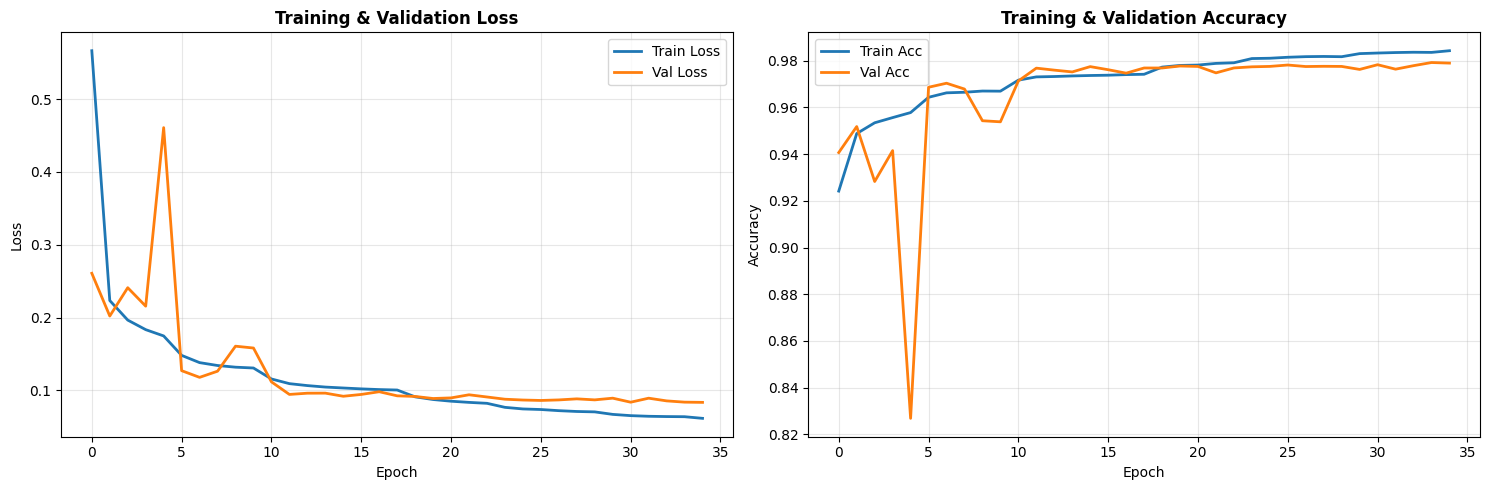

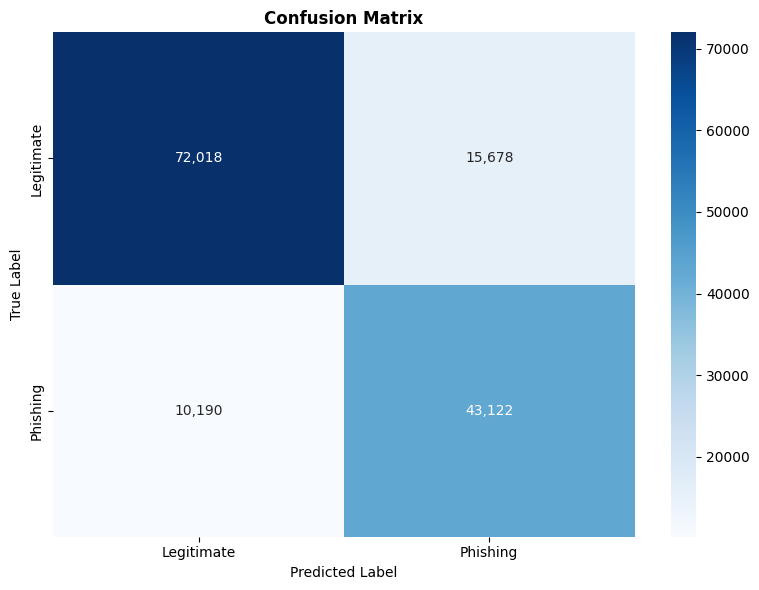

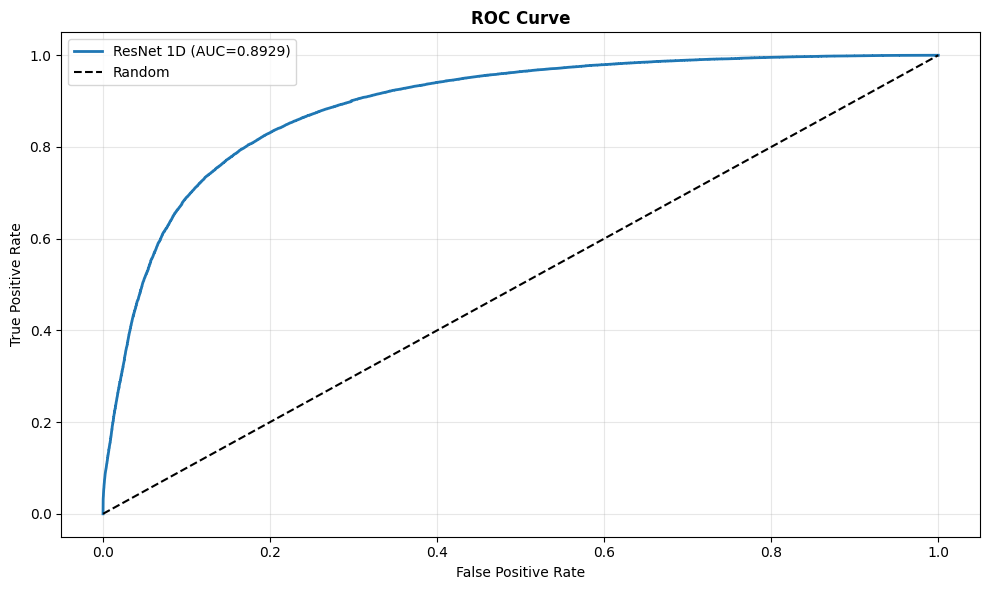

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve

# --- 1. Training History ---
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training & Validation Loss', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history.history['accuracy'], label='Train Acc', linewidth=2)
axes[1].plot(history.history['val_accuracy'], label='Val Acc', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training & Validation Accuracy', fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# --- 2. Confusion Matrix ---
# Đảm bảo cm đã được tính
cm = confusion_matrix(y_test, y_pred_opt)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt=',d', cmap='Blues',
           xticklabels=['Legitimate', 'Phishing'],
           yticklabels=['Legitimate', 'Phishing'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix', fontweight='bold')
plt.tight_layout()
plt.show()

# --- 3. ROC Curve ---
# Tính AUC trước khi dùng
auc = roc_auc_score(y_test, y_pred_proba)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, linewidth=2, label=f'ResNet 1D (AUC={auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
def run_internal_finetuning_robust(model, X_test_in, y_test_in, threshold):
    # --- 1. CHUẨN HÓA DỮ LIỆU ---
    # Nếu X_test là list có 1 phần tử, rút nó ra
    if isinstance(X_test_in, list) and len(X_test_in) == 1:
        X_test_clean = np.array(X_test_in[0])
    elif isinstance(X_test_in, list):
        # Model 2 nhánh -> Giữ nguyên list các array
        X_test_clean = [np.array(x) for x in X_test_in]
    else:
        # Model 1 nhánh -> Đảm bảo là numpy array
        X_test_clean = np.array(X_test_in)
        
    # Chuẩn hóa y_test thành (N, 1) và kiểu float32 Đảm bảo shape nhất quán
    y_test_clean = np.array(y_test_in).astype('float32').flatten()
    
    # Kiểm tra kích thước mẫu
    n_samples = len(y_test_clean)
    if isinstance(X_test_clean, list):
        n_samples = len(X_test_clean[0])
    elif hasattr(X_test_clean, 'shape'):
        n_samples = X_test_clean.shape[0]
        
    print(f"   - Tổng mẫu xác nhận: {n_samples}")

    # --- 2. CHIA TẬP TEST BẰNG INDEX ---
    indices = np.arange(n_samples)
    idx_ft, idx_eval = train_test_split(
        indices, 
        test_size=0.85, 
        random_state=SEED, 
        stratify=y_test_clean
    )
    
    # Hàm cắt dữ liệu an toàn
    def slice_data(data, idx):
        if isinstance(data, list): 
            return [d[idx] for d in data]
        return data[idx]

    X_ft = slice_data(X_test_clean, idx_ft)
    X_eval = slice_data(X_test_clean, idx_eval)
    y_ft = y_test_clean[idx_ft]
    y_eval = y_test_clean[idx_eval]
    
    # --- 3. ĐÁNH GIÁ BASELINE ---
    # Thêm batch_size để tránh OOM
    loss_before, acc_before = model.evaluate(X_eval, y_eval, verbose=0, batch_size=32)
    print(f"   -> Accuracy ban đầu (ngưỡng mặc định): {acc_before:.2%}")

    # --- 4. ĐÓNG BĂNG & COMPILE ---
    # Bước 1: Khóa toàn bộ mô hình 
    for layer in model.layers:
        layer.trainable = False
        
    # Bước 2: Mở khóa TOÀN BỘ các lớp Batch Normalization
    # Để cập nhật lại Mean/Variance, giải quyết Concept Drift trên tập test
    for layer in model.layers:
        if isinstance(layer, BatchNormalization):
            layer.trainable = True

    # Bước 3: Chỉ mở khóa đúng 2 lớp Dense ở phần Head (Output)
    # Bằng cách lặp ngược từ cuối mô hình lên để tránh dính vào Dense của khối SE Block
    unfrozen_dense_count = 0
    for layer in reversed(model.layers):
        if isinstance(layer, Dense):
            layer.trainable = True
            unfrozen_dense_count += 1
            # Mô hình có 1 lớp Dense(128) và 1 lớp Dense(1) ở Head
            if unfrozen_dense_count == 2: 
                break

    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=5e-5),
        metrics=['accuracy']
    )
    
    # --- 5. FINE-TUNE ---
    model.fit(X_ft,
              y_ft,
              epochs=5,
              batch_size=32,
              verbose=1)

    # --- 6. ĐÁNH GIÁ SAU KHI HỌC ---
    loss_after, acc_after = model.evaluate(X_eval, y_eval, verbose=0, batch_size=32)
    print(f"   -> Accuracy sau học (ngưỡng mặc định): {acc_after:.2%} (Cải thiện: {acc_after - acc_before:+.2%})")

    # --- 7. BÁO CÁO CHI TIẾT ---
    y_prob = model.predict(X_eval, verbose=0, batch_size=32).flatten()
    y_pred = (y_prob > threshold).astype(int)
    
    print("\n--- CLASSIFICATION REPORT với ngưỡng ưu tiên recall ---")
    print(classification_report(y_eval.flatten(), y_pred, target_names=['Legit', 'Phishing']))

    y_pred = (y_prob > 0.5).astype(int)
    
    print("\n--- CLASSIFICATION REPORT với ngưỡng mặc định ---")
    print(classification_report(y_eval.flatten(), y_pred, target_names=['Legit', 'Phishing']))
    
    return model

# CHẠY, giữ ngưỡng đã tìm được trước đó
model = run_internal_finetuning_robust(model, X_test, y_test, OPTIMAL_THRESHOLD)

   - Tổng mẫu xác nhận: 141008
   -> Accuracy ban đầu (ngưỡng mặc định): 82.29%
Epoch 1/5
661/661 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - accuracy: 0.8304 - loss: 0.8438
Epoch 2/5
661/661 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9131 - loss: 0.2774
Epoch 3/5
661/661 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9332 - loss: 0.2027
Epoch 4/5
661/661 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9386 - loss: 0.1723
Epoch 5/5
661/661 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9475 - loss: 0.1555
   -> Accuracy sau học (ngưỡng mặc định): 96.98% (Cải thiện: +14.69%)

--- CLASSIFICATION REPORT với ngưỡng ưu tiên recall ---
              precision    recall  f1-score   support

       Legit       0.98      0.96      0.97     74542
    Phishing       0.93      0.96      0.95     45315

    accuracy                           0.96    119857
   macro avg       0.96      0.96      0.96    119857
weighted avg       0.96      0.96      0.96    119857


--- CLASSIFICATION REPORT với ngưỡng m

In [ ]:
import os
import json
import pickle
import numpy as np
from datetime import datetime

def save_model_package(model, tokenizer, history, config, save_dir='/kaggle/working/model_export'):
    """
    Lưu toàn bộ thông tin cần thiết để triển khai mô hình:
    - Model (.keras)
    - Tokenizer (pickle)
    - Lịch sử huấn luyện (JSON)
    - Cấu hình & siêu tham số (JSON)
    """
    os.makedirs(save_dir, exist_ok=True)
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    
    # 1. LƯU MODEL
    # Định dạng .keras (Keras 3 native)
    model_path = os.path.join(save_dir, f'resnet1d_se_{timestamp}.keras')
    model.save(model_path)
    print(f"Model đã lưu:     {model_path}")
    
    # Lưu thêm chỉ trọng số
    weights_path = os.path.join(save_dir, f'weights_{timestamp}.weights.h5')
    model.save_weights(weights_path)
    print(f"Weights đã lưu:   {weights_path}")
    
    # 2. LƯU TOKENIZER
    tokenizer_path = os.path.join(save_dir, f'tokenizer_{timestamp}.pkl')
    with open(tokenizer_path, 'wb') as f:
        pickle.dump(tokenizer, f)
    print(f"Tokenizer đã lưu: {tokenizer_path}")
    
    # 3. LƯU LỊCH SỬ HUẤN LUYỆN
    # Chuyển numpy types sang Python types để JSON serialize được
    history_data = {}
    if history is not None:
        for key, values in history.history.items():
            history_data[key] = [float(v) for v in values]
    
    history_path = os.path.join(save_dir, f'history_{timestamp}.json')
    with open(history_path, 'w', encoding='utf-8') as f:
        json.dump(history_data, f, indent=2, ensure_ascii=False)
    print(f"History đã lưu:   {history_path}")
    
    # 4. LƯU CẤU HÌNH & SIÊU THAM SỐ
    config_path = os.path.join(save_dir, f'config_{timestamp}.json')
    with open(config_path, 'w', encoding='utf-8') as f:
        json.dump(config, f, indent=2, ensure_ascii=False)
    print(f"Config đã lưu:    {config_path}")
    
    # 5. TẠO FILE README
    readme_path = os.path.join(save_dir, 'README.txt')
    with open(readme_path, 'w', encoding='utf-8') as f:
        f.write("PHISHING URL DETECTION - ResNet 1D + SE Block\n")
        f.write(f"Ngày tạo:        {timestamp}\n")
        f.write(f"Tổng tham số:    {model.count_params():,}\n")
        f.write(f"VOCAB_SIZE:      {config.get('VOCAB_SIZE', 'N/A')}\n")
        f.write(f"MAX_LEN:         {config.get('MAX_LEN', 'N/A')}\n")
        f.write(f"EMBED_DIM:       {config.get('EMBED_DIM', 'N/A')}\n")
        f.write(f"Ngưỡng tối ưu: {config.get('OPTIMAL_THRESHOLD', 'N/A')}\n\n")
        f.write("Các file:\n")
        f.write(f"  - Model:     resnet1d_se_{timestamp}.keras\n")
        f.write(f"  - Weights:   weights_{timestamp}.weights.h5\n")
        f.write(f"  - Tokenizer: tokenizer_{timestamp}.pkl\n")
        f.write(f"  - History:   history_{timestamp}.json\n")
        f.write(f"  - Config:    config_{timestamp}.json\n\n")
        f.write("Cách load lại:\n")
        f.write("  # Lời khuyên: Thêm compile=False khi load để dự đoán (Inference) cho nhẹ\n")
        f.write("  model = tf.keras.models.load_model('resnet1d_se_xxx.keras', compile=False)\n")
        f.write("  with open('tokenizer_xxx.pkl', 'rb') as f:\n")
        f.write("      tokenizer = pickle.load(f)\n")
    print(f"README đã lưu:    {readme_path}")
    
    print(f"Tất cả file đã lưu tại: {save_dir}")
    
    return save_dir

# GỌI HÀM LƯU

# Đóng gói toàn bộ cấu hình
model_config = {
    # Siêu tham số
    'SEED': SEED,
    'VOCAB_SIZE': VOCAB_SIZE,
    'MAX_LEN': MAX_LEN,
    'EMBED_DIM': EMBED_DIM,
    'BATCH_SIZE': BATCH_SIZE,
    'EPOCHS': EPOCHS,
    'L2_RATE': L2_RATE,
    'SE_RATIO': SE_RATIO,
    
    # --- THÔNG SỐ LOSS ---
    'loss_function': 'binary_crossentropy',
    'class_weights_train': {str(k): float(v) for k, v in weight_dict.items()},
    
    # Ngưỡng phân loại
    'OPTIMAL_THRESHOLD': float(OPTIMAL_THRESHOLD),
    'DEFAULT_THRESHOLD': 0.5,
    
    # Thông tin dữ liệu
    'train_samples': len(X_train),
    'val_samples': len(X_val),
    'test_samples': len(X_test),
    
    # Kiến trúc
    'architecture': 'ResNet_1D_SE',
    
    'residual_blocks': [
        {'filters': 32,  'kernel_size': 9},
        {'filters': 64,  'kernel_size': 7},
        {'filters': 128, 'kernel_size': 5},
        {'filters': 256, 'kernel_size': 3},
    ],
    'dense_head': 128,
    'dropout_rate': 0.3,
    'spatial_dropout': 0.2,
    
    # Kết quả
    'results': {
        'val_accuracy': float(history.history['val_accuracy'][-1]) if history else None,
        'val_loss': float(history.history['val_loss'][-1]) if history else None,
    }
}

# Lưu tất cả
save_dir = save_model_package(
    model=model,
    tokenizer=tokenizer,
    history=history,
    config=model_config
)

Model đã lưu:     /kaggle/working/model_export/resnet1d_se_20260224_165928.keras
Weights đã lưu:   /kaggle/working/model_export/weights_20260224_165928.weights.h5
Tokenizer đã lưu: /kaggle/working/model_export/tokenizer_20260224_165928.pkl
History đã lưu:   /kaggle/working/model_export/history_20260224_165928.json
Config đã lưu:    /kaggle/working/model_export/config_20260224_165928.json
README đã lưu:    /kaggle/working/model_export/README.txt
Tất cả file đã lưu tại: /kaggle/working/model_export


In [ ]:
import json
import pickle
import math
from collections import Counter
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 1. HÀM TÍNH ENTROPY
def calculate_entropy(text):
    if not text:
        return 0
    entropy = 0
    for x in Counter(text).values():
        p_x = x / len(text)
        entropy += - p_x * math.log2(p_x)
    return entropy

# 2. LOAD MODEL PACKAGE TỪ THƯ MỤC EXPORT
def load_model_package(save_dir='/kaggle/working/model_export'):
    import glob
    model_files = sorted(glob.glob(os.path.join(save_dir, '*.keras')))
    tokenizer_files = sorted(glob.glob(os.path.join(save_dir, 'tokenizer_*.pkl')))
    config_files = sorted(glob.glob(os.path.join(save_dir, 'config_*.json')))
    
    if not model_files:
        raise FileNotFoundError(f"Không tìm thấy model trong {save_dir}")

    model = tf.keras.models.load_model(model_files[-1], compile=False)
    
    with open(tokenizer_files[-1], 'rb') as f:
        tokenizer = pickle.load(f)
        
    with open(config_files[-1], 'r', encoding='utf-8') as f:
        config = json.load(f)
        
    return model, tokenizer, config

# KHỞI TẠO DANH SÁCH TRẮNG
Tranco_FILE_PATH = '/kaggle/input/datasets/quangnguynv/top-1-million-sites/top-1m-Tranco-list.csv' 
GLOBAL_TRUSTED_DOMAINS = set(['kaggle.com', 'google.com', 'github.com', 'microsoft.com', 'apple.com'])

try:
    if os.path.exists(Tranco_FILE_PATH):
        df_tranco = pd.read_csv(Tranco_FILE_PATH, header=None)
        top_domains = df_tranco[1].astype(str).str.lower().tolist()
        GLOBAL_TRUSTED_DOMAINS.update(top_domains[:])
        print(f"Đã tải {len(GLOBAL_TRUSTED_DOMAINS)} domains vào Danh sách Trắng.")
except Exception as e:
    print(f"Không tìm thấy file Tranco. Dùng danh sách mặc định. Lỗi: {e}")
    
# 3. HÀM DỰ ĐOÁN
def predict_url(raw_url, model, tokenizer, config):
    """
    Test nhanh kết quả mô hình ngay trong Kaggle
    """
    # Không chạy unshorten_url ở Kaggle vì mạng bị giới hạn, test link thật luôn
    entropy_score = calculate_entropy(str(raw_url))
    
    url_clean = clean_url(raw_url)
    domain = url_clean.split('/')[0]
    main_domain = '.'.join(domain.split('.')[-2:]) if '.' in domain else domain
    
    # Ép cấu trúc (Masking)
    url_masked = sanitize_url(url_clean)
    
    # Tokenize + Pad
    seq = tokenizer.texts_to_sequences([url_masked])
    padded = pad_sequences(seq, maxlen=config['MAX_LEN'], padding='post', truncating='post')
    
    # Dự đoán
    prob = float(model.predict(padded, verbose=0).flatten()[0])
    threshold = config.get('OPTIMAL_THRESHOLD', 0.5)
    
    # Áp dụng logic cộng trừ điểm (Whitelist & Entropy)
    if main_domain in GLOBAL_TRUSTED_DOMAINS or domain in GLOBAL_TRUSTED_DOMAINS:
        prob = prob * 0.6
    elif entropy_score > 4.5:
        prob = min(1.0, prob + 0.1)
    
    label = 'PHISHING' if prob > threshold else 'LEGIT'
    
    return {
        "url": raw_url,
        "masked_url": url_masked,
        "entropy": entropy_score,
        "probability": prob,
        "threshold": threshold,
        "prediction": label
    }

# KIỂM TRA LUỒNG CHẠY THỰC TẾ 
try:
    loaded_model, loaded_tokenizer, loaded_config = load_model_package()
    
    # Các URL test bao gồm cả trường hợp chứa chuỗi sinh ngẫu nhiên
    test_urls = [
        'sites.google.com/view/secure-login-vietcombank-vnn/home',
        'leetcode.com/problems/sum-of-root-to-leaf-binary-numbers/?envType=daily-question&envId=2026-02-24',
        'domain-rac.com/paypal-update-account-security-login',
        'kaggle.com/code/quangnguynv/phishing-url-detection-using-cnn-skip-connection/edit/run/299181815',
        'facebook-login-secure.xyz/verify',
        'paypal.com.site.ru/login?token=eyJhbGciOiJIUzI1NiIsInR5cCI6IkpXVCJ9', # Base64/JWT
        'gemini.google.com/app/a444aa5776ddda71',
        'free-iphone15.click/claim-now?q=z9y8x7w6v5u4t3s2r1q0p9o8n7m6l5k4j3i2h1g0f' # Cố tình lách luật
    ]

    print("KẾT QUẢ DỰ ĐOÁN\n")

    for url in test_urls:
        result = predict_url(url, loaded_model, loaded_tokenizer, loaded_config)
        print(f"  URL gốc:    {result['url']}")
        print(f"  URL masked: {result['masked_url']}")
        print(f"  Entropy:    {result['entropy']:.4f}")
        print(f"  Xác suất:   {result['probability']:.4f}")
        print(f"  Ngưỡng:     {result['threshold']:.4f}")
        print(f"  Kết quả:    {result['prediction']}")
        
except Exception as e:
    print(f"Vui lòng tạo thư mục và train model trước. Lỗi: {e}")

Đã tải 1000000 domains vào Danh sách Trắng.
KẾT QUẢ DỰ ĐOÁN

  URL gốc:    sites.google.com/view/secure-login-vietcombank-vnn/home
  URL masked: sites.google.com/view/secure-login-vietcombank-vnn/home
  Entropy:    4.1369
  Xác suất:   0.6960
  Ngưỡng:     0.2451
  Kết quả:    PHISHING
  URL gốc:    leetcode.com/problems/sum-of-root-to-leaf-binary-numbers/?envType=daily-question&envId=2026-02-24
  URL masked: leetcode.com/problems/sum-of-root-to-leaf-binary-numbers/?envtype=daily-question&envid=<DATE_10>
  Entropy:    4.6345
  Xác suất:   0.1245
  Ngưỡng:     0.2451
  Kết quả:    LEGIT
  URL gốc:    domain-rac.com/paypal-update-account-security-login
  URL masked: domain-rac.com/paypal-update-account-security-login
  Entropy:    4.0547
  Xác suất:   0.9737
  Ngưỡng:     0.2451
  Kết quả:    PHISHING
  URL gốc:    kaggle.com/code/quangnguynv/phishing-url-detection-using-cnn-skip-connection/edit/run/299181815
  URL masked: kaggle.com/code/quangnguynv/phishing-url-detection-using-cnn-skip